In [760]:
import pandas as pd
import numpy as np
import scipy
import time
import random
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

**Analysis pipeline**

#1) EDA (understand feature distribution, missing data, class imbalance)
#2) Dimensionality reduction 
#3) Model evaluation
#4) Failure mode analysis

In [761]:
df_raw=pd.read_csv('C:\\Users\\teek2\\Documents\\BreastCancerDetection\\Data\\breast-cancer-wisconsin.txt').drop(columns=['Normal Nucleoli','Single Epithelial Cell Size','Bare Nuclei'])

In [762]:
print('number of data rows: {}'.format(len(df_raw)))

number of data rows: 15855


In [763]:
import missingno as msno

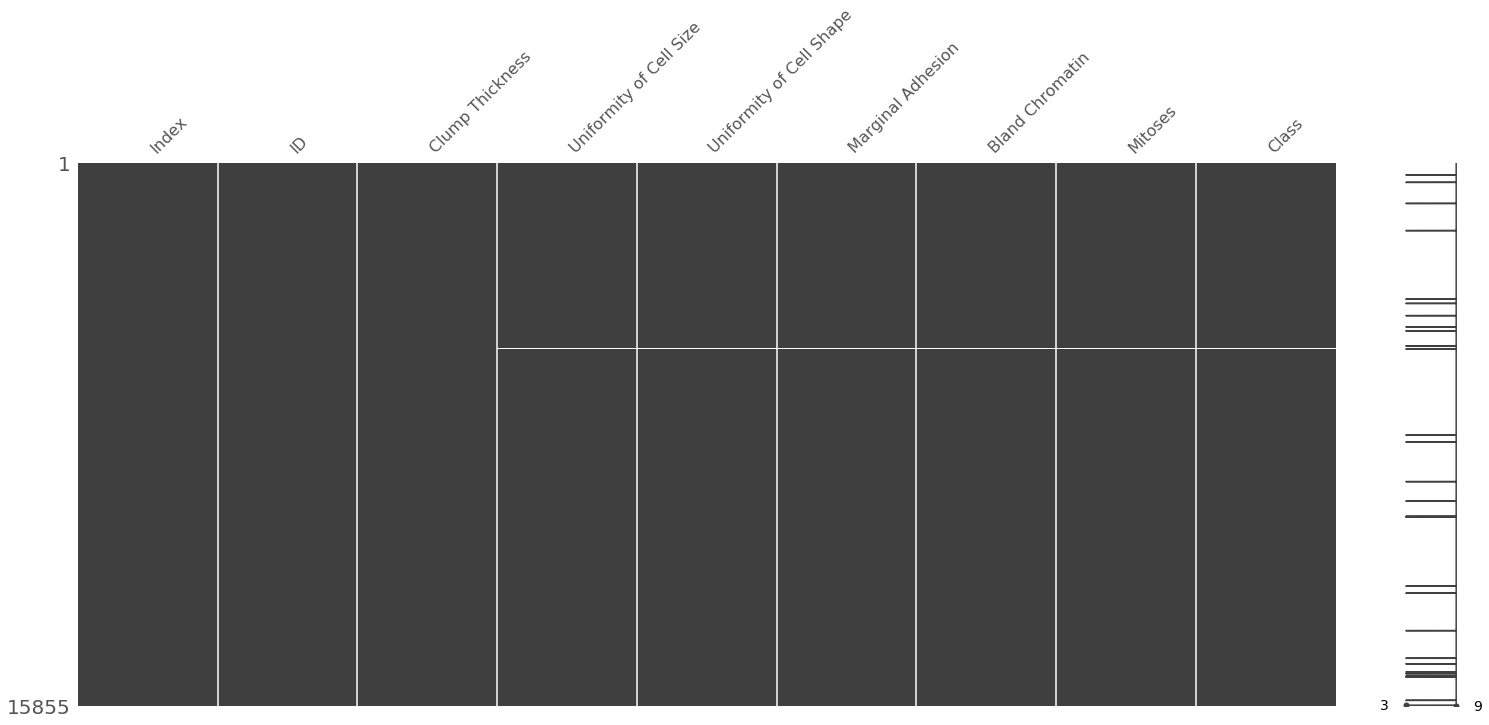

In [764]:
msno.matrix(df_raw)

In [765]:
#I want to see what the possible outputs are for each of my features

for i in range(2,len(df_raw.iloc[0])):
    print(df_raw.columns[i]+' unique values: {}'.format(df_raw.iloc[:,i].unique()))

Clump Thickness unique values: [  7   6   8   5  10   3   4   1  70  80 100   2   9  50  30  40  60]
Uniformity of Cell Size unique values: ['8' '10' '6' '5' '4' '9' '3' '1' 'No idea' '2' '7' '50' '100' '30' nan
 '#' '?' '80' '40' '60' '90' '20']
Uniformity of Cell Shape unique values: ['3' '5' '4' '6' '10' '7' '1' 'No idea' '2' '60' '100' '40' nan '#' '9'
 '8' '?' '30' '50' '70']
Marginal Adhesion unique values: ['7' '5' '10' '3' '6' '4' '1' '2' 'No idea' '30' '40' nan '#' '8' '?' '70'
 '60' '100' '50' '9' '20']
Bland Chromatin unique values: ['7' '6' '3' '2' '4' 'No idea' '1' '5' '70' '30' nan '40' '#' '10' '8' '?'
 '20' '9' '60' '50']
Mitoses unique values: ['2' '1' '7' 'No idea' '3' '10' '70' '8' nan '20' '#' '6' '?' '4' '5']
Class unique values: ['4' '2' 'No idea' '40' nan '#' '?' '20']


In [766]:
#Let's convert everything to numbers
for i in range(2,len(df_raw.iloc[0])):
    df_raw[df_raw.columns[i]]=pd.to_numeric(df_raw[df_raw.columns[i]],errors='coerce')

In [767]:
#the most common error seems to be that things are listed on a 0-100 scale than a 0-10 scale or a 20/40 class id instead of 2/4 id
#so let's remap

df_raw=df_raw.replace({20:2,30:3,40:4,50:5,60:6,70:7,80:8,90:9,100:10})
df_raw['Class']=df_raw['Class'].replace({4:0,2:1})

In [768]:
print('number of positive cases in data set (pre-clean): {}'.format(len(df_raw[df_raw['Class']==1])))

number of positive cases in data set (pre-clean): 461


In [769]:
#let's look at fraction of missing data
#it seems low enough to consider just dropping data

#I'm concerned if we drop missing data, we will lose precious positive test cases, but it turns out by dropping missing
#data we do not drop any data that was definitively labeled as malicious tumors so I think we are okay for now


print('fraction of data w/ missing values: {}'.format((len(df_raw)-len(df_raw.dropna()))/len(df_raw))) #very low amount of missing data, can probably safely ignore for now although I will comeback to this later
print('number of positive cases in data set (with rows w/ missing values removed): {}'.format(len(df_raw.dropna()[df_raw.dropna()['Class']==1])))

fraction of data w/ missing values: 0.004982655313781142
number of positive cases in data set (with rows w/ missing values removed): 461


In [770]:
print('number of malicious tumors: {}'.format(len(df_raw[df_raw['Class']==1])))
print('number of benign tumors: {}'.format(len(df_raw[df_raw['Class']==0])))

number of malicious tumors: 461
number of benign tumors: 15315


In [771]:
#let's select the features we want to use (methodology described below)
#also now that data is cleaned, let's separate our data into train/test components 

df=df_raw.dropna()
df.drop(['Uniformity of Cell Shape'],inplace=True,axis=1)
df['Mitoses']=df['Mitoses'].apply(lambda x: np.log(x+1))

features=['Clump Thickness', 'Marginal Adhesion',
       'Bland Chromatin', 'Mitoses','Uniformity of Cell Size']
X=df[features]
Y=df['Class']
X_train_dev,X_test,y_train_dev,y_test=train_test_split(X,Y)

#positive class split seems roughly aligned with the 1:3 ratio we would expect from randomization

print('number of test set malicious tumors: {}'.format(np.sum(y_test)))
print('number of train/dec set malicious tumors: {}'.format(np.sum(y_train_dev)))

number of test set malicious tumors: 113.0
number of train/dec set malicious tumors: 348.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


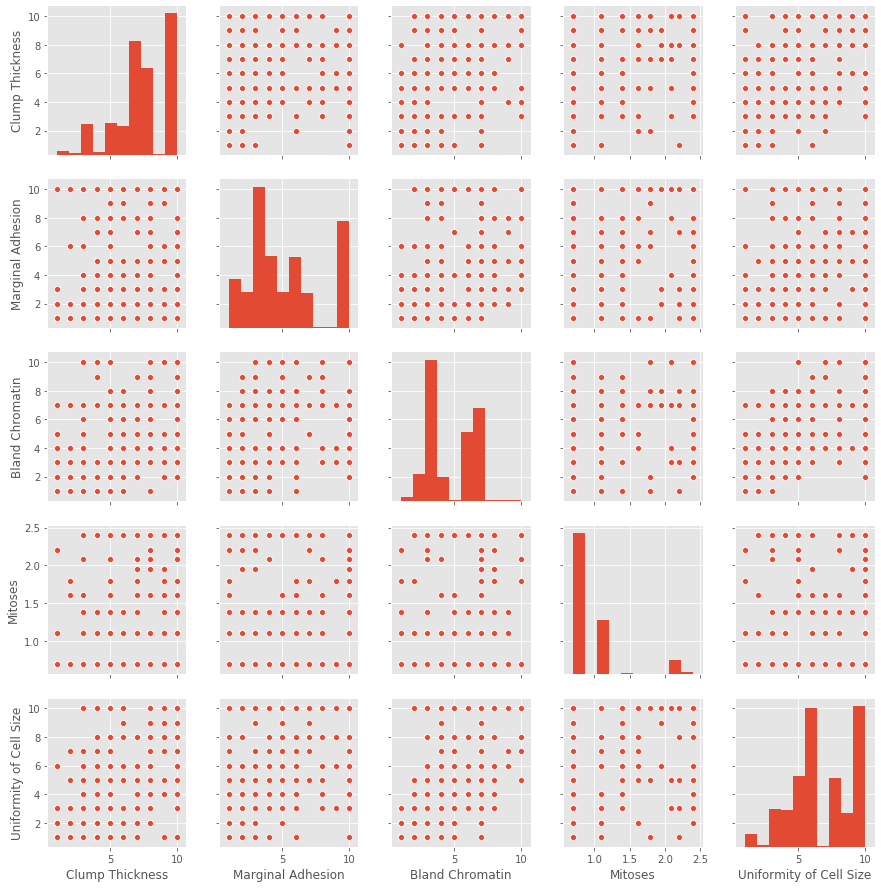

In [772]:
#now let's plot these features
sns.pairplot(X_train_dev) #features seem fairly uncorrelated which is good

Text(0.5, 1, 'Feature Correlation Matrix')

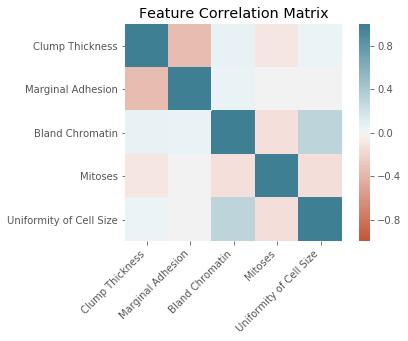

In [773]:
#let's look at correlation between features

corr = X_train_dev.corr() #doesn't seem to be too much multicolinearity either which is good
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

ax.set_title('Feature Correlation Matrix')

Text(0.5, 1.0, 'Tumor class correlation')

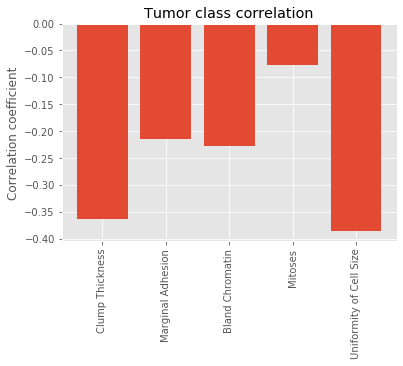

In [774]:
#now let's get a sense of how each feature is correalted with class prediciton

pearson_r=[0]*len(features)
for i,feat in enumerate(features):
    pearson_r[i]=scipy.stats.pearsonr(X_train_dev[feat],y_train_dev)[0]
plt.figure()
plt.bar(features,pearson_r)
plt.xticks(rotation=90)
plt.ylabel('Correlation coefficient')
plt.title('Tumor class correlation')

In [775]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [776]:
#let's look at the VIF factors for our data
#they are <10 so I think we are okay on multi-colinearity concerns

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_dev.values, i) for i in range(X_train_dev.shape[1])]
vif["features"] = X_train_dev.columns
vif[['features','VIF Factor']]

,features,VIF Factor
0,Clump Thickness,8.387311
1,Marginal Adhesion,3.520704
2,Bland Chromatin,7.393210
3,Mitoses,4.909986
4,Uniformity of Cell Size,8.356534


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':


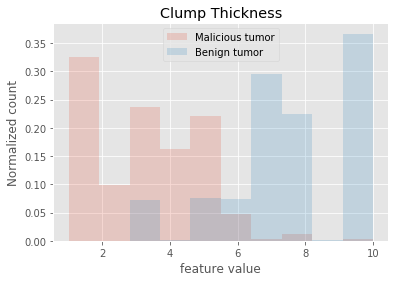

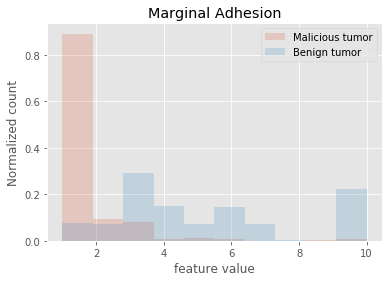

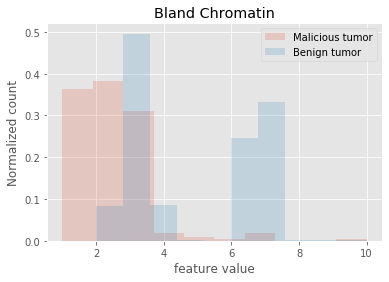

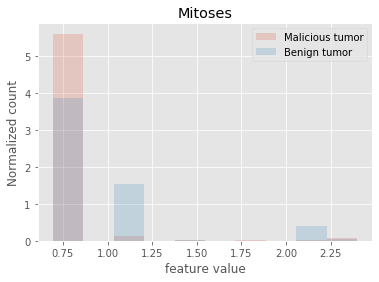

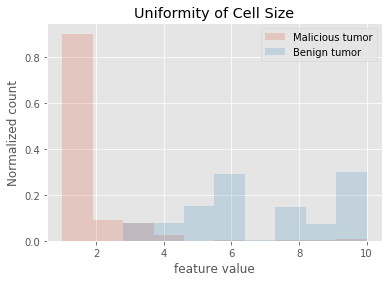

In [777]:
#now let's plot a hist of each feature and look at differences in benign/malicious tumors
#thickness and cell/size are obviosuly going to be important to classification

df_train=pd.concat([X_train_dev,y_train_dev],axis=1)
df_pos=df_train[df_train['Class']==1]
df_neg=df_train[df_train['Class']==0]
feature_names=X_train_dev.columns

for feature in feature_names:
    plt.figure()
    plt.hist(df_pos[feature],label='Malicious tumor',normed=True,alpha=.2)
    plt.hist(df_neg[feature],label='Benign tumor',normed=True,alpha=.2)
    plt.legend()
    plt.xlabel('feature value')
    plt.ylabel('Normalized count')
    plt.title(feature)


In [778]:
#let's separate our data into dev/train sets

scaler = preprocessing.StandardScaler().fit(X_train_dev)
X_dev=scaler.transform(X_train_dev[-int(.8*len(X_train_dev)):])
y_dev=y_train_dev[-int(.8*len(X_train_dev)):]
X_train=X_train_dev[:int(.8*len(X_train_dev))]
y_train=y_train_dev[:int(.8*len(X_train_dev))]

In [779]:
#we want to upsample our minority class since there is class imbalance

from sklearn.utils import resample

# separate minority and majority classes
X_us = pd.concat([X_train, y_train], axis=1)

not_fraud = X_us[X_us.Class==0]
fraud = X_us[X_us.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

In [780]:
X_train=scaler.transform(upsampled.iloc[:,0:-1])
y_train=upsampled.iloc[:,-1]

In [781]:
#going to start with a simple LR model

lr=LogisticRegression()

In [782]:
#let's do a grid search over regularization parameter, keeping recall as an optimization metric

from sklearn.model_selection import GridSearchCV
parameters = {'C':[.1, 1, 5, 10]}
clf = GridSearchCV(lr, parameters,scoring='recall')
clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None, param_grid={'C': [0.1, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [783]:
#best recall for train set obtained
clf.best_score_

0.9709466811751903

In [784]:
#best reg. coefficient for train set obtained
clf.best_params_

{'C': 0.1}

In [785]:
lr=LogisticRegression(C= clf.best_params_['C'])
lr.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [786]:
#metrics for validation set 

from sklearn.metrics import classification_report
print(classification_report(y_dev,lr.predict(X_dev)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9193
         1.0       0.96      0.97      0.97       272

    accuracy                           1.00      9465
   macro avg       0.98      0.99      0.98      9465
weighted avg       1.00      1.00      1.00      9465



In [787]:
#metrics for test set

from sklearn.metrics import classification_report
print(classification_report(y_test,lr.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3831
         1.0       0.89      0.97      0.93       113

    accuracy                           1.00      3944
   macro avg       0.95      0.99      0.97      3944
weighted avg       1.00      1.00      1.00      3944



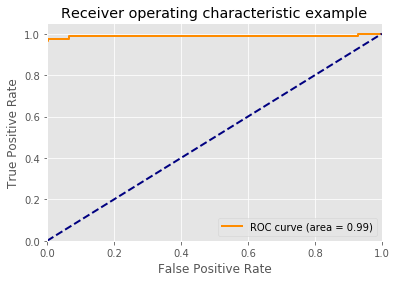

In [788]:
#let's look at the ROC curve 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
y_score = lr.decision_function(X_test)


# Compute ROC curve and ROC area for each class


fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


lw = 2
plt.plot(fpr, tpr, color='darkorange', \
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'feature importance: LR coefficients')

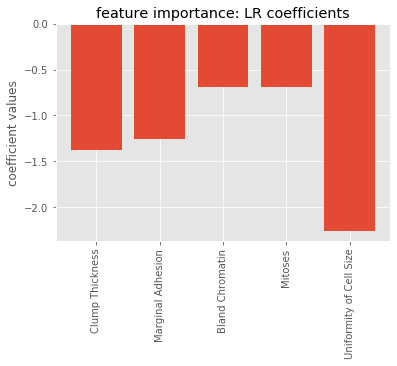

In [789]:
# feature importance using the LR coefficients

plt.style.use('ggplot')
from matplotlib import pyplot as plt
import matplotlib as mp
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)   

plt.figure()
plt.bar([i for i in range(len(lr.coef_[0]))],list(lr.coef_[0]),tick_label=list(X_test.columns))
plt.xticks(rotation=90)
plt.ylabel('coefficient values')
plt.title('feature importance: LR coefficients')

Text(0.5, 1.0, 'feature importance: permutation test')

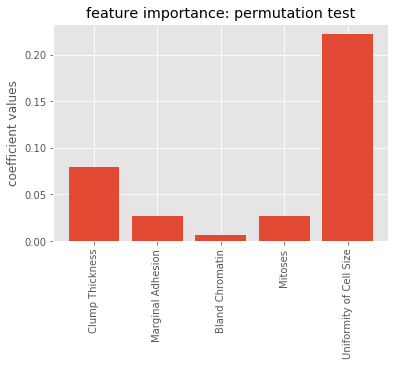

In [790]:
#feature importances using permutation test

from sklearn.inspection import permutation_importance

r = permutation_importance(lr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

plt.figure()
plt.bar([i for i in range(len(lr.coef_[0]))],r.importances_mean,tick_label=list(X_test.columns))
plt.xticks(rotation=90)
plt.ylabel('coefficient values')
plt.title('feature importance: permutation test')

In [791]:
predict_vectors=pd.DataFrame({'Predicted Class':lr.predict(scaler.transform(X_test))})
df_results=pd.concat([X_test.reset_index(),y_test.reset_index(),predict_vectors],axis=1)

In [792]:
df_fp=df_results[(df_results['Predicted Class']==1) & (df_results['Class']==0)]
df_fp=df_fp.drop(columns=['index'])

df_fn=df_results[(df_results['Predicted Class']==0) & (df_results['Class']==1)]
df_fn=df_fn.drop(columns=['index'])


df_tp=df_results[(df_results['Predicted Class']==1) & (df_results['Class']==1)]
df_tp=df_tp.drop(columns=['index'])

df_tn=df_results[(df_results['Predicted Class']==0) & (df_results['Class']==0)]
df_tn=df_tn.drop(columns=['index'])

Text(0.5, 1.0, 'True positive feature distributions')

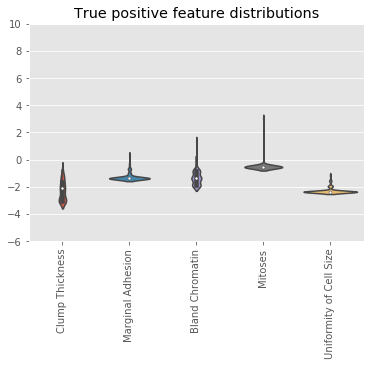

In [793]:
#let's look at distribution of features amongst the different prediciton outcomes from our classifier

fig, axes = plt.subplots()
sns.violinplot(data=scaler.transform(df_tp.iloc[:,0:-2]),ax=axes)
axes.set_xticklabels(labels=df_tp.columns[:-2],rotation=90)
axes.set_ylim(-6,10)
axes.set_title('True positive feature distributions')

Text(0.5, 1.0, 'False positive feature distributions')

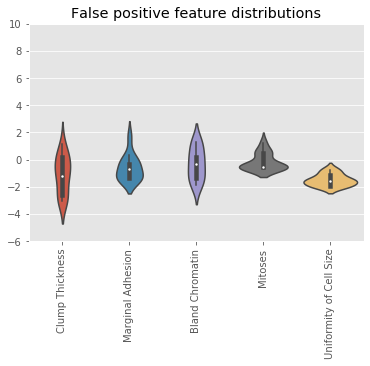

In [794]:
fig, axes = plt.subplots()
sns.violinplot(data=scaler.transform(df_fp.iloc[:,0:-2]),ax=axes)
axes.set_xticklabels(labels=df_fp.columns[:-2],rotation=90)
axes.set_ylim(-6,10)
axes.set_title('False positive feature distributions')

Text(0.5, 1.0, 'True negative feature distributions')

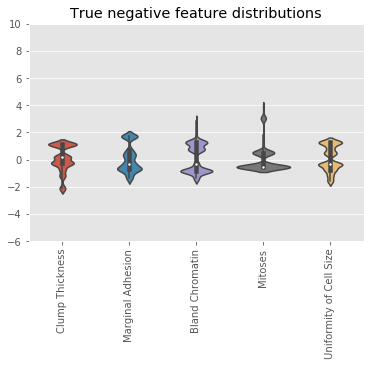

In [795]:
fig, axes = plt.subplots()
sns.violinplot(data=scaler.transform(df_tn.iloc[:,0:-2]),ax=axes)
axes.set_xticklabels(labels=df_tn.columns[:-2],rotation=90)
axes.set_ylim(-6,10)
axes.set_title('True negative feature distributions')

Text(0.5, 1.0, 'False negative feature distributions')

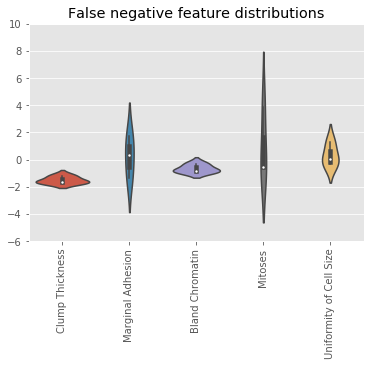

In [796]:
fig, axes = plt.subplots()
sns.violinplot(data=scaler.transform(df_fn.iloc[:,0:-2]),ax=axes)
axes.set_xticklabels(labels=df_fn.columns[:-2],rotation=90)
axes.set_ylim(-6,10)
axes.set_title('False negative feature distributions')

In [797]:
#let's look at the avergae feature values for their prediciton outcomes as well

cluster_df=pd.concat([df_tp.mean(),df_fp.mean(),df_tn.mean(),df_fn.mean()],axis=1)
cluster_df.columns=['True Positive','False Positive','True Negative','False Negative']
cluster_df.round(1)

,True Positive,False Positive,True Negative,False Negative
Clump Thickness,2.6,5.2,7.7,4.3
Marginal Adhesion,1.3,3.2,5.2,5.7
Bland Chromatin,2.1,4.0,4.7,3.3
Mitoses,0.7,0.8,0.9,1.3
Uniformity of Cell Size,1.2,3.2,7.1,7.7
Class,1.0,0.0,0.0,1.0
Predicted Class,1.0,1.0,0.0,0.0


In [798]:
#finally, let's see what the individual failures that we care about most (false negatives) look like
df_fn

,Clump Thickness,Marginal Adhesion,Bland Chromatin,Mitoses,Uniformity of Cell Size,Class,Predicted Class
1568,4,6.0,4.0,0.693147,6.0,1.0,0.0
1574,5,1.0,3.0,0.693147,7.0,1.0,0.0
1901,4,10.0,3.0,2.397895,10.0,1.0,0.0
